In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import unicodedata
from sklearn.model_selection import train_test_split
import pandas as pd


In [0]:
# Get Dataset

path_to_zip = tf.keras.utils.get_file(fname='spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
path_to_zip

'/root/.keras/datasets/spa-eng.zip'

In [0]:
os.listdir(os.path.dirname(path_to_zip)+'/spa-eng')

['_about.txt', 'spa.txt']

In [0]:
file_path = os.path.join(os.path.dirname(path_to_zip), 'spa-eng/spa.txt')

In [0]:
file_path

'/root/.keras/datasets/spa-eng/spa.txt'

In [0]:
# Read Data
!head -n 3 /root/.keras/datasets/spa-eng/spa.txt

Go.	Ve.
Go.	Vete.
Go.	Vaya.


In [0]:
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['eng', 'spa']

In [0]:
df.head()

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.


In [0]:
# Text Clean Function
# 1) convert unicode character

def unicode_to_ascii(sentence):
  converted = []
  for char in unicodedata.normalize('NFD', sentence):
    if unicodedata.category(char) != 'Mn':
      converted.append(char)
  final_result = ''.join(converted)
  return final_result

In [0]:
# Testing
unicode_to_ascii(df.iloc[3, 1])

'Vayase.'

In [0]:
for i in unicodedata.normalize('NFD', df.iloc[3, 1]):
  print(f'{i} \t Category: {unicodedata.category(i)}')

V 	 Category: Lu
a 	 Category: Ll
́ 	 Category: Mn
y 	 Category: Ll
a 	 Category: Ll
s 	 Category: Ll
e 	 Category: Ll
. 	 Category: Po


In [0]:
# Text Clean Function
# 2) Clean text with regex

def clean_text(sentence):
  sentence = unicode_to_ascii(sentence.lower().strip())
  sentence = re.sub(r'([!?.,¿])', r' \1 ', sentence)
  sentence = re.sub(r'[" "]+', ' ', sentence)
  sentence = re.sub(r'[^a-zA-Z!?.,¿]+', ' ', sentence)
  sentence = sentence.rstrip().strip()
  sentence = '<start> ' + sentence + ' <end>'

  return sentence

In [0]:
clean_text(df.iloc[3, 1])

'<start> vayase . <end>'

In [0]:
df['eng'] = df['eng'].apply(clean_text)
df['spa'] = df['spa'].apply(clean_text)

In [0]:
df.head()

,eng,spa
0,<start> go . <end>,<start> ve . <end>
1,<start> go . <end>,<start> vete . <end>
2,<start> go . <end>,<start> vaya . <end>
3,<start> go . <end>,<start> vayase . <end>
4,<start> hi . <end>,<start> hola . <end>


In [0]:
eng = df['eng'].tolist()
spa = df['spa'].tolist()

In [0]:
def max_tensor_checker(tensor):
  length_checker = [len(batch) for batch in tensor]
  return max(length_checker)

In [0]:
def language_tokenizer(language):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(language)

  language_tensor = tokenizer.texts_to_sequences(language)
  max_length = max_tensor_checker(language_tensor)
  
  language_tensor = tf.keras.preprocessing.sequence.pad_sequences(language_tensor, max_length, padding='post')

  return tokenizer, max_length, language_tensor

In [0]:
eng_token, eng_max_length, eng_tensor = language_tokenizer(eng)
spa_token, spa_max_length, spa_tensor = language_tokenizer(spa)

In [0]:
eng_vocab = len(eng_token.word_index)
spa_vocab = len(spa_token.word_index)

In [0]:
# The model purpose is 
# English - > spanish

spa_tensor

array([[   1,  364,    3, ...,    0,    0,    0],
       [   1, 1321,    3, ...,    0,    0,    0],
       [   1,  500,    3, ...,    0,    0,    0],
       ...,
       [   1,   22, 5873, ...,    0,    0,    0],
       [   1,   37, 1305, ...,    0,    0,    0],
       [   1,   44,  121, ..., 2100,    3,    2]], dtype=int32)

In [0]:
# create spa_input 
spa_input_tensor = np.zeros(shape=spa_tensor.shape, dtype=np.int)
spa_input_tensor[:, :-1] = spa_tensor[:, 1:]

In [0]:
spa_input_tensor

array([[ 364,    3,    2, ...,    0,    0,    0],
       [1321,    3,    2, ...,    0,    0,    0],
       [ 500,    3,    2, ...,    0,    0,    0],
       ...,
       [  22, 5873,    5, ...,    0,    0,    0],
       [  37, 1305,  140, ...,    0,    0,    0],
       [  44,  121, 1440, ...,    3,    2,    0]])

In [0]:
test_eng = eng_tensor[:32]
test_spa = spa_tensor[:32]

In [0]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.units = units

    self.W_a = tf.keras.layers.Dense(units, use_bias=False)
    self.W_b = tf.keras.layers.Dense(units, use_bias=False)
    self.V = tf.keras.layers.Dense(1, use_bias=False)

  def call(self, inputs):
    
    enc_output = inputs[0]
    dec_hidden = inputs[1]

    dec_hidden = tf.expand_dims(dec_hidden, 1)

    h_t = self.V(tf.nn.tanh(self.W_a(enc_output) + self.W_b(dec_hidden)))
    # print(h_t.shape)

    a_ts = tf.nn.softmax(h_t, axis=1)
    # print(a_ts.shape)

    context_vector = tf.reduce_sum(a_ts * dec_hidden, axis=1)
    # print(context_vector.shape)
    return context_vector, a_ts 

In [0]:
attention_layer = Attention(128)

In [0]:
att_result, att_weight = attention_layer([sample_output, sample_hidden])
print()
print(att_result.shape)
print(att_weight.shape)

(32, 51, 1)
(32, 51, 1)
(32, 128)

(32, 128)
(32, 51, 1)


In [0]:
# encoder 
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state
  
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(eng_vocab+1, 128, 128, 32)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(test_eng, sample_hidden)

In [0]:
sample_output.shape

TensorShape([32, 51, 128])

In [0]:
sample_hidden.shape

TensorShape([32, 128])

In [0]:
# decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)

    self.attention = Attention(self.dec_units)

  def call(self, inputs):
    enc_output = inputs[2]
    hidden = inputs[1]
    dec_input = inputs[0]
    
    context_vector, attention_weight = self.attention([enc_output, hidden])


    z = self.embedding(dec_input)
    
    z = tf.concat([tf.expand_dims(context_vector, 1), z], axis=-1)

    output_, state = self.gru(z)
    output_ = tf.reshape(output_, (-1, output_.shape[2]))

    z = self.fc(output_) 
    return z, state, attention_weight

In [0]:
decoder = Decoder(spa_vocab + 1, 128, 128, 32)

sample_decode_output, _, _ = decoder([test_spa, sample_hidden, sample_output])

(32, 51, 1)
(32, 51, 1)
(32, 128)


In [0]:
spa_vocab+1

24794

In [0]:
test_spa.shape

(32, 53)

In [0]:
sample_decode_output.shape

TensorShape([1696, 24794])

In [0]:
spa_tensor.shape

(118964, 53)

In [0]:
BUFFER_SIZE = len(eng_tensor)
BATCH_SIZE = 32
steps_per_epoch = len(eng_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(eng_token.word_index)+1
vocab_tar_size = len(spa_token.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((eng_tensor, spa_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
next(iter(dataset))

(<tf.Tensor: shape=(32, 51), dtype=int32, numpy=
 array([[   1,    7,   22, ...,    0,    0,    0],
        [   1,   57,    7, ...,    0,    0,    0],
        [   1,   86,   95, ...,    0,    0,    0],
        ...,
        [   1,   13, 3414, ...,    0,    0,    0],
        [   1,   13,   19, ...,    0,    0,    0],
        [   1,   34,  147, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32, 53), dtype=int32, numpy=
 array([[   1,   90, 3637, ...,    0,    0,    0],
        [   1,   12, 1351, ...,    0,    0,    0],
        [   1,   20,   66, ...,    0,    0,    0],
        ...,
        [   1,   16, 8144, ...,    0,    0,    0],
        [   1,    6,   46, ...,    0,    0,    0],
        [   1,   24,  125, ...,    0,    0,    0]], dtype=int32)>)

In [0]:
encoder = Encoder(eng_vocab+1, 128, 128, 32)
# sample_hidden = encoder.initialize_hidden_state()
# sample_output, sample_hidden = encoder(test_eng, sample_hidden)


decoder = Decoder(spa_vocab + 1, 128, 128, 32)
# sample_decode_output, _, _ = decoder([test_spa, sample_hidden, sample_output])

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):

  loss = 0
  
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([spa_token.word_index['<start>']] * BATCH_SIZE, 1)

    for t in range(1, targ.shape[1]): # train lstm by feeding the time step by updating
      predictions, dec_hidden, _ = decoder([dec_input, dec_hidden, enc_output])

      loss += loss_function(targ[:, t], predictions)

      dec_input = tf.expand_dims(targ[:, t], 1)
    
    batch_loss = (loss / int(targ.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss


In [184]:
EPOCHS = 10
for epoch in range(EPOCHS):

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))


Epoch 1 Batch 0 Loss 1.7123
Epoch 1 Batch 100 Loss 0.7975
Epoch 1 Batch 200 Loss 0.8471
Epoch 1 Batch 300 Loss 0.9534
Epoch 1 Batch 400 Loss 0.8963
Epoch 1 Batch 500 Loss 0.7007
Epoch 1 Batch 600 Loss 0.7730
Epoch 1 Batch 700 Loss 0.6927
Epoch 1 Batch 800 Loss 0.7806
Epoch 1 Batch 900 Loss 0.7602
Epoch 1 Batch 1000 Loss 0.6850
Epoch 1 Batch 1100 Loss 0.7350
Epoch 1 Batch 1200 Loss 0.7772
Epoch 1 Batch 1300 Loss 0.7588
Epoch 1 Batch 1400 Loss 0.7408
Epoch 1 Batch 1500 Loss 0.6519
Epoch 1 Batch 1600 Loss 0.7519
Epoch 1 Batch 1700 Loss 0.7140
Epoch 1 Batch 1800 Loss 0.6709
Epoch 1 Batch 1900 Loss 0.7112
Epoch 1 Batch 2000 Loss 0.6096
Epoch 1 Batch 2100 Loss 0.6453
Epoch 1 Batch 2200 Loss 0.7088
Epoch 1 Batch 2300 Loss 0.6627
Epoch 1 Batch 2400 Loss 0.6352
Epoch 1 Batch 2500 Loss 0.6375
Epoch 1 Batch 2600 Loss 0.7531
Epoch 1 Batch 2700 Loss 0.6121
Epoch 1 Batch 2800 Loss 0.6767
Epoch 1 Batch 2900 Loss 0.6705
Epoch 1 Batch 3000 Loss 0.6635
Epoch 1 Batch 3100 Loss 0.5931
Epoch 1 Batch 3200 L

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((spa_max_length, eng_max_length))

  sentence = clean_text(sentence)

  inputs = [eng_token.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = eng_max_length, padding='post')

  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, 128))]

  enc_output, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden

  dec_input = tf.expand_dims([spa_token.word_index['<start>']], 0)
  for t in range(spa_max_length):
    predictions, dec_hidden, attention_weight = decoder([dec_input, dec_hidden, enc_output])
    print(predictions.shape)
    print(dec_hidden.shape)
    print(attention_weight.shape)

    attention_weight = tf.reshape(attention_weight, (-1,))
    print(attention_weight.shape)
    attention_plot[t] = attention_weight.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += spa_token.index_word[predicted_id] + ' '

    if spa_token.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    
    dec_input = tf.expand_dims([predicted_id], 0)
  
  return result, sentence, attention_plot

In [0]:
import matplotlib.ticker as ticker
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  print(attention_plot)
  print(attention_plot.shape)

  print(sentence)
  print(result)
  print('-----')
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [211]:
eng_max_length

51

(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
[[0.01743674 0.03230498 0.01544521 ... 0.02415393 0.02425202 0.02434803]
 [0.01805727 0.04076324 0.02131176 ... 0.02240931 0.02247568 0.02254072]
 [0.02074163 0.05731313 0.02166856 ... 0.02345541 0.02354385 0.02363033]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(53, 51)
<start> what time is it ? <end>
¿ a que hora es ? <end> 
-----


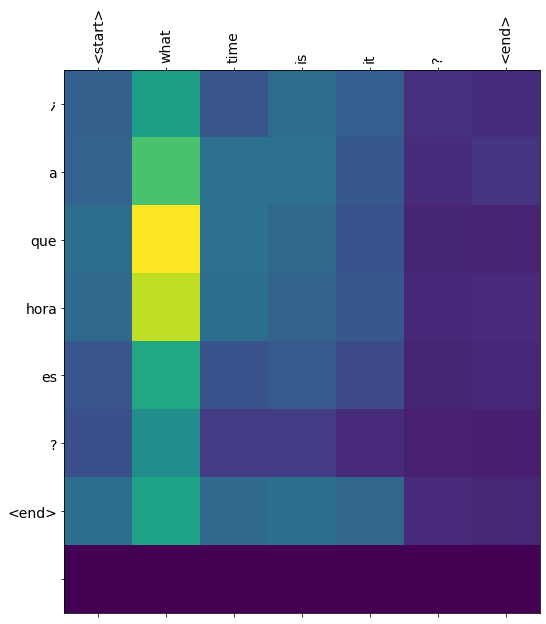

In [210]:
translate("what time is it?")

(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
(1, 24794)
(1, 128)
(1, 51, 1)
(51,)
[[0.01743674 0.03230498 0.01544521 ... 0.02415393 0.02425202 0.02434803]
 [0.01805727 0.04076324 0.02131176 ... 0.02240931 0.02247568 0.02254072]
 [0.02074163 0.05731313 0.02166856 ... 0.02345541 0.02354385 0.02363033]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(53, 51)
<start> what time is it ? <end>
¿ a que hora es ? <end> 
-----


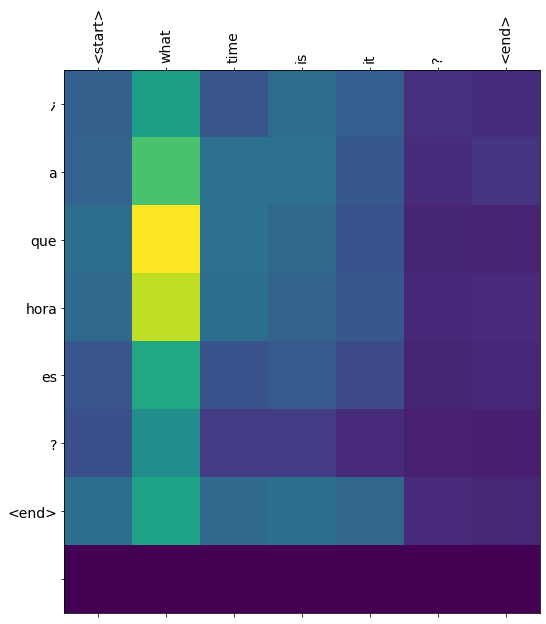

In [212]:
sentence = "what time is it?"

result, sentence, attention_plot = evaluate(sentence)
print(attention_plot)
print(attention_plot.shape)

print(sentence)
print(result)
print('-----')
attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [215]:
result

'¿ a que hora es ? <end> '

In [216]:
result.split(' ')

['¿', 'a', 'que', 'hora', 'es', '?', '<end>', '']

In [214]:
attention_plot[:]

array([0.01743674, 0.03230498, 0.01544521, 0.02030926, 0.01706936,
       0.00807759, 0.00748109])

In [0]:
tf.expand_dims([spa_token.word_index['<start>']], 0)

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]], dtype=int32)>

In [0]:
tf.expand_dims([spa_token.word_index['<start>']] * BATCH_SIZE, 1)

<tf.Tensor: shape=(32, 1), dtype=int32, numpy=
array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)>